# Sample run for Fisher Market

In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/workspace/ExchangeMarket.jl/scripts`


In [2]:
using Revise
using Random, SparseArrays, LinearAlgebra
using JuMP, MosekTools
using Plots, LaTeXStrings, Printf
import MathOptInterface as MOI
using Plots, LaTeXStrings, Printf, JLD2
using ExchangeMarket

include("../tools.jl")
include("../plots.jl")
include("./setup.jl")
switch_to_pdf(; bool_use_html=true)


@load "../../dataset/ml-32m.jld2" S
bool_part = true
if bool_part
    m = 5000
    n = 2000
    T = S[1:n, 1:m]
else
end
S, cols, rows = ExchangeMarket.drop_empty(T)
n, m = size(S)
# S = Matrix(S)
S = S .* 2.0
ϵₚ = 1e-6


┌ Warning: `PlotlyKaleido` 2.3.0 is not compatible with this version of `Plots`. The declared compatibility is 1.
└ @ Plots /Users/brent/.julia/packages/Plots/FFuQi/src/backends.jl:55


1.0e-6

## Test a CES Economy

Run CES economy by different methods

In [3]:
using LinearAlgebra, LinearOperators, Krylov

In [4]:
ρs = 0.9 * ones(m)
f0 = FisherMarket(m, n; c=S, ρ=ρs, bool_unit=true, scale=30.0, sparsity=0.2)

linconstr = LinearConstr(1, n, ones(1, n), [sum(f0.w)])

# -----------------------------------------------------------------------
# compute ground truth
# -----------------------------------------------------------------------
f1 = copy(f0)
p₀ = ones(n) * sum(f1.w) ./ (n)
x₀ = ones(n, m) ./ m
f1.x .= x₀
f1.p .= p₀
# use log-barrier method to compute ground truth
(name, method, kwargs) = method_kwargs[1]
kwargs = Dict(
    :tol => 1e-12, :maxiter => 20,
    :optimizer => CESAnalytic,
    # :option_mu => :pred_corr,
    :option_mu => :normal,
    #
    :option_step => :affinesc,
    # :option_step => :homotopy,
    # :option_step => :logbar,
    # :linsys => :DRq,
    :linsys => :krylov,
    # :linsys => :direct,
)
alg = method(
    n, m, p₀;
    linconstr=linconstr,
    kwargs...
)
traj = opt!(
    alg, f1;
    loginterval=1,
    maxiter=1,
    keep_traj=true,
    bool_init_phase=false,
)
pₛ = copy(alg.p);


FisherMarket initialization started...
FisherMarket cost matrix initialized in 0.0456 seconds
FisherMarket initialized in 0.1128 seconds
FisherMarket initialization started...
FisherMarket cost matrix initialized in 0.0721 seconds
FisherMarket initialized in 0.0723 seconds
----------------------------------------------------------------------------------
              ExchangeMarket.jl: A Julia Package for Exchange Market              
                              © Chuwen Zhang (2024)                              
----------------------------------------------------------------------------------
 subproblem solver alias       := CESAnalytic
 subproblem solver style       := analytic
 lin-system solver alias       := krylov + optimal diagonal scaling
 option for gradient           := dual
 option for step               := affinesc
 option for μ                  := normal
 !!! linear constraint is not supported for affine-scaling and will be ignored
------------------------------------

In [5]:
@time ExchangeMarket.__compute_exact_hess_optimized!(alg, f1)
H = diagm(alg.p) * alg.H * diagm(alg.p)

  0.036072 seconds (10.07 k allocations: 107.384 MiB)


┌ Info: exact dense Hessian built (heterogeneous σ)
└ @ ExchangeMarket /Users/brent/workspace/ExchangeMarket.jl/src/algorithms/diff.jl:223


2000×2000 Matrix{Float64}:
  0.0199039    -0.000464593  -2.89907e-5   …  -6.51145e-6   -8.27039e-8
 -0.000464593   0.0182334    -3.65754e-5      -9.50747e-7   -1.08817e-8
 -2.89907e-5   -3.65754e-5    0.00867588      -1.98587e-7   -8.59228e-10
 -8.60282e-6   -4.58759e-6   -5.2532e-6       -1.32873e-7    0.0
 -0.000156099  -0.000811802  -0.00013605      -8.40728e-7   -5.36087e-8
 -0.000188068  -5.43046e-5   -1.93695e-5   …  -3.97532e-6   -4.34266e-8
 -0.00043787   -0.000662112  -7.76316e-5      -2.09232e-6   -4.72837e-8
 -2.14938e-8   -4.96199e-8   -4.18622e-8       0.0           0.0
 -0.000120187  -0.000115335  -1.79946e-5      -4.67848e-6   -3.94807e-8
 -7.66747e-5   -0.000242715  -2.6689e-5       -3.36236e-6   -2.94199e-8
  ⋮                                        ⋱                
 -1.78375e-8   -8.65642e-9   -4.93957e-8      -5.80948e-8   -4.467e-8
 -4.00587e-6   -4.24251e-6   -2.06909e-6      -1.02997e-7   -5.03458e-10
 -2.89557e-7   -1.11768e-6   -2.42406e-6      -1.0097e-7    -7

## Baseline

### use Hessian-vector product operator

In [6]:
ExchangeMarket.__update_php_hessop!(alg, f1)
d, stats = cg(alg.Hk.php_hessop, alg.p .* alg.∇; verbose=3, timemax=10.0, history=true)

CG: system of 2000 equations in 2000 variables
    k      ‖r‖       pAp         α         σ  timer
    0  5.1e-02   1.3e-04   2.0e+01   2.0e+01  0.09s
    3  4.1e-02   6.5e-05   2.6e+01   2.6e+01  0.16s
    6  3.4e-02   3.4e-05   3.4e+01   3.4e+01  0.17s
    9  3.6e-02   3.5e-05   3.6e+01   3.6e+01  0.18s
   12  3.8e-02   3.8e-05   3.8e+01   3.8e+01  0.19s
   15  4.0e-02   3.6e-05   4.4e+01   4.4e+01  0.19s
   18  4.4e-02   5.6e-05   3.5e+01   3.5e+01  0.20s
   21  3.3e-02   2.2e-05   5.1e+01   5.1e+01  0.21s
   24  3.0e-02   1.8e-05   4.9e+01   4.9e+01  0.22s
   27  2.7e-02   1.8e-05   4.3e+01   4.3e+01  0.22s
   30  2.5e-02   1.1e-05   5.7e+01   5.7e+01  0.23s
   33  2.5e-02   1.0e-05   6.1e+01   6.1e+01  0.24s
   36  3.2e-02   4.1e-05   2.5e+01   2.5e+01  0.25s
   39  2.9e-02   1.5e-05   5.6e+01   5.6e+01  0.25s
   42  2.6e-02   1.5e-05   4.7e+01   4.7e+01  0.26s
   45  2.7e-02   4.5e-05   1.6e+01   1.6e+01  0.27s
   48  2.1e-02   6.3e-06   6.7e+01   6.7e+01  0.28s
   51  2.8e-02   

([-0.11401874749529645, -0.12050037076441526, -0.06768147607340683, 0.5321749500508701, -0.1327322303721563, -0.12714312313953696, -0.11522953891858777, 9.673363071412203, -0.15393539466470246, -0.13084869445514638  …  4.612992945819968, 3.3510747798680005, 0.2750464818986019, 0.20373558991844612, 3.0025136479123407, 0.09547445774596436, 4.782889447815402, 53.33632914224045, 0.37123652158567017, 8.916593100160128], SimpleStats
 niter: 1521
 solved: true
 inconsistent: false
 indefinite: false
 residuals: [ 5.1e-02  5.0e-02  4.7e-02 ...  2.6e-08  2.0e-08  1.5e-08 ]
 Aresiduals: []
 κ₂(A): []
 timer: 5.09s
 status: solution good enough given atol and rtol
)

### use explicit Hessian

In [7]:
ExchangeMarket.__update_php_hessop!(alg, f1)
d, stats = cg(H, alg.p .* alg.∇; verbose=3, timemax=10.0)

CG: system of 2000 equations in 2000 variables
    k      ‖r‖       pAp         α         σ  timer
    0  5.1e-02   1.3e-04   2.0e+01   2.0e+01  0.00s
    3  4.1e-02   6.5e-05   2.6e+01   2.6e+01  0.00s
    6  3.4e-02   3.4e-05   3.4e+01   3.4e+01  0.00s
    9  3.6e-02   3.5e-05   3.6e+01   3.6e+01  0.00s
   12  3.8e-02   3.8e-05   3.8e+01   3.8e+01  0.00s
   15  4.0e-02   3.6e-05   4.4e+01   4.4e+01  0.01s
   18  4.4e-02   5.6e-05   3.5e+01   3.5e+01  0.01s
   21  3.3e-02   2.2e-05   5.1e+01   5.1e+01  0.01s
   24  3.0e-02   1.8e-05   4.8e+01   4.8e+01  0.01s
   27  2.6e-02   1.4e-05   4.9e+01   4.9e+01  0.01s
   30  2.5e-02   1.1e-05   5.7e+01   5.7e+01  0.01s
   33  2.5e-02   1.0e-05   6.2e+01   6.2e+01  0.01s
   36  3.2e-02   3.8e-05   2.6e+01   2.6e+01  0.01s
   39  2.9e-02   1.5e-05   5.6e+01   5.6e+01  0.01s
   42  2.7e-02   1.5e-05   4.7e+01   4.7e+01  0.01s
   45  2.8e-02   5.8e-05   1.4e+01   1.4e+01  0.01s
   48  2.2e-02   1.2e-05   3.9e+01   3.9e+01  0.01s
   51  2.3e-02   

([-0.11210214420838034, -0.11862041390379303, -0.06567660266715997, 0.5343890558644245, -0.13075050001630192, -0.1250251051572816, -0.11333978264283001, 9.72333086266941, -0.1520428378645174, -0.1288957031520933  …  4.626903345195909, 3.359009996732588, 0.2773308160359224, 0.20612736613817004, 3.009222060667232, 0.09771307622309192, 4.796899630201419, 55.16663945836642, 0.37403649329154753, 8.95902997870631], SimpleStats
 niter: 1665
 solved: true
 inconsistent: false
 indefinite: false
 residuals: []
 Aresiduals: []
 κ₂(A): []
 timer: 499.17ms
 status: solution good enough given atol and rtol
)

## Diagonal preconditioner

### without any

In [8]:
a = rand(n)
d, stats = cg(alg.Hk.php_hessop, alg.p .* alg.∇, a; verbose=3, timemax=10.0, history=true)

CG: system of 2000 equations in 2000 variables
    k      ‖r‖       pAp         α         σ  timer
    0  1.8e-01   2.7e-03   1.2e+01   1.2e+01  0.01s
    3  7.7e-02   2.2e-04   2.7e+01   2.7e+01  0.01s
    6  5.1e-02   7.5e-05   3.4e+01   3.4e+01  0.02s
    9  3.6e-02   3.5e-05   3.7e+01   3.7e+01  0.03s
   12  3.3e-02   3.5e-05   3.2e+01   3.2e+01  0.04s
   15  2.8e-02   1.9e-05   4.1e+01   4.1e+01  0.05s
   18  3.2e-02   2.8e-05   3.6e+01   3.6e+01  0.06s
   21  3.5e-02   3.3e-05   3.7e+01   3.7e+01  0.07s
   24  3.4e-02   2.6e-05   4.4e+01   4.4e+01  0.08s
   27  4.3e-02   6.1e-05   2.9e+01   2.9e+01  0.08s
   30  3.4e-02   2.0e-05   5.7e+01   5.7e+01  0.09s
   33  2.8e-02   1.4e-05   5.6e+01   5.6e+01  0.10s
   36  2.5e-02   1.1e-05   5.3e+01   5.3e+01  0.11s
   39  2.2e-02   8.8e-06   5.7e+01   5.7e+01  0.12s
   42  2.2e-02   7.4e-06   6.5e+01   6.5e+01  0.13s
   45  2.5e-02   2.2e-05   3.0e+01   3.0e+01  0.14s
   48  2.4e-02   8.9e-06   6.6e+01   6.6e+01  0.14s
   51  2.6e-02   

([-0.1140187935523772, -0.12050038174231456, -0.0676814719500296, 0.5321749075475789, -0.13273223514436655, -0.12714315544080734, -0.11522960615438177, 9.673362706549682, -0.15393536287038379, -0.13084871394212566  …  4.612993159054053, 3.3510742484737905, 0.27504645451718257, 0.20373558441845965, 3.0025132410934994, 0.09547440980565891, 4.782889491554021, 53.33632942781579, 0.37123652009295915, 8.916593306297774], SimpleStats
 niter: 1520
 solved: true
 inconsistent: false
 indefinite: false
 residuals: [ 1.8e-01  1.3e-01  1.0e-01 ...  2.7e-08  1.9e-08  1.6e-08 ]
 Aresiduals: []
 κ₂(A): []
 timer: 4.55s
 status: solution good enough given atol and rtol
)

### optimal diagonal preconditioning

In [9]:
ExchangeMarket.__update_php_hessop!(alg, f1)
τ = 1 ./ sum(H; dims=2)[:]  # diagonal preconditioner
P⁻¹ = diagm(τ)
d1, stats1 = cg(H, alg.p .* alg.∇ .- alg.μ, a; M=P⁻¹, rtol=1e-15, verbose=3, timemax=5.0, history=true)

CG: system of 2000 equations in 2000 variables
    k      ‖r‖       pAp         α         σ  timer
    0  6.9e+00   4.3e+02   1.1e-01   1.1e-01  0.00s
    3  3.4e-01   2.5e-01   4.6e-01   4.6e-01  0.00s
    6  1.4e-02   1.3e-03   1.4e-01   1.4e-01  0.01s
    9  1.3e-04   1.1e-07   1.5e-01   1.5e-01  0.01s
   12  1.2e-06   9.8e-12   1.4e-01   1.4e-01  0.01s
   15  9.7e-09



([-0.11254818037887987, -0.11906324849241359, -0.06614618931670113, 0.5336197284104245, -0.1311873723853364, -0.12546500079099154, -0.11378520674068643, 9.717942650341875, -0.15246894611967066, -0.1293335138586551  …  4.624081955646629, 3.356827592714139, 0.2766895398603732, 0.2055218458129623, 3.0072139756398197, 0.09716176949690392, 4.793993878730728, 55.131893215758026, 0.3733469188715025, 8.954034172728608], SimpleStats
 niter: 15
 solved: true
 inconsistent: false
 indefinite: false
 residuals: [ 6.9e+00  1.7e+00  6.4e-01 ...  2.5e-07  5.1e-08  9.7e-09 ]
 Aresiduals: []
 κ₂(A): []
 timer: 17.23ms
 status: solution good enough given atol and rtol
)

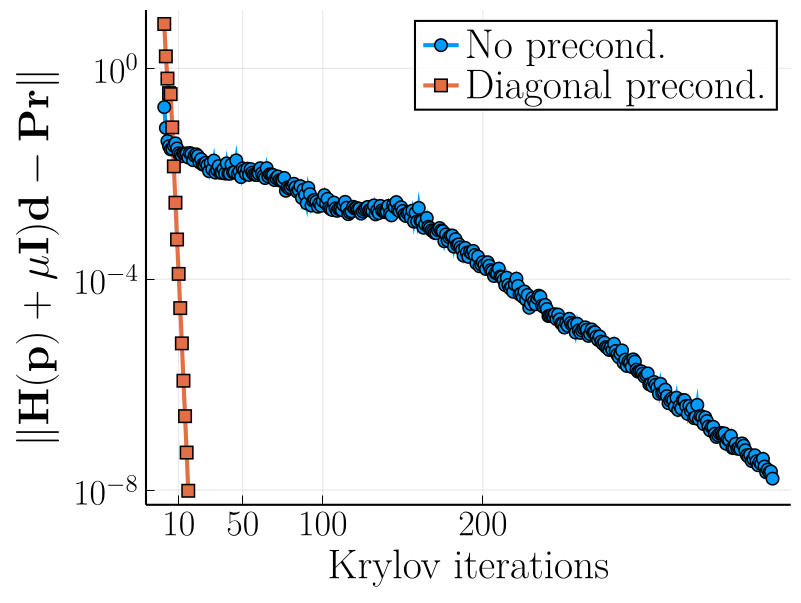

In [10]:
fig = generate_empty(; shape=:wide)
plot!(
    fig,
    ylabel=L"$\|\mathbf{H}(\mathbf{p}) + \mu \mathbf{I})\mathbf{d} - \mathbf{P}\mathbf{r}\|$",
    # title=L"$\rho := %$ρfmt~(\sigma := %$σfmt)$",
    legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
    yticks=10.0 .^ (-16:4:3),
    xtickfont=font(18),
    ytickfont=font(18),
    xscale=:identity,
    size=(500, 400),
    xlabel=L"$\textrm{Krylov iterations}$"
)
plot!(
    fig,
    xticks=[10, 50, 100, 200, 500]
)

plot!(fig, stats.residuals[1:4:end], label=L"\textrm{No precond.}", linewidth=2, markershape=:circle)
plot!(fig, stats1.residuals, label=L"\textrm{Diagonal precond.}", linewidth=2, markershape=:rect)


In [11]:
savefig(fig, "/tmp/linsys_precond.pdf")

"/tmp/linsys_precond.pdf"

## Eigenvalues

In [12]:
eigen(sqrt.(P⁻¹) * H * sqrt.(P⁻¹))

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2000-element Vector{Float64}:
  1.0000000000000044
  1.000000000000007
  3.235437080815151
  4.317903689814229
  4.706641823069047
  4.740914884939813
  5.041459464511836
  5.114927418272597
  5.147857981563676
  5.422834349258924
  ⋮
  9.999834294522666
  9.999857500288142
  9.999875812778493
  9.99999999999999
 10.000000000000016
 10.000000000000016
 10.000000000000048
 10.000000000000062
 10.000000000000252
vectors:
2000×2000 Matrix{Float64}:
 0.046965     6.18931e-7  -0.000156503  …  -1.14704e-15  -7.62663e-15
 0.0452553    5.96399e-7  -0.000153378     -2.64103e-14  -2.71898e-14
 0.0311225    4.1015e-7   -8.08304e-5      -5.5664e-14    2.38794e-15
 0.00922724   1.21602e-7  -1.69416e-5      -9.22542e-15  -4.70881e-14
 0.0679141    8.95011e-7  -0.000179628      1.99334e-14  -1.40592e-14
 0.0493069    6.49795e-7  -3.46576e-5   …  -4.99763e-14  -8.15539e-14
 0.0472465    6.22641e-7  -0.000169275      4.58113e-14   2.5968

### A strict upper bound

In [13]:
ρₘ = maximum(ρs)
κ = 1 / (1 - ρₘ)

10.000000000000002